## Convolutional Neural Networks

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](https://medium.com/@alexattia18) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://drive.google.com/drive/folders/171GKxRx2SCjLfcfYSPbIa1HzpR6ha3-s?usp=sharing) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://drive.google.com/drive/folders/1B4L6Pk1x9cbfvbP1uQTBSD959_n3QdvL?usp=sharing) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

Todo el dataset en un solo enlace([Enlace_descarga_completo](https://drive.google.com/file/d/1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La/view?usp=sharing))


## Carga de los datos

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
import glob
%matplotlib inline

# Crear directorios base
!mkdir -p /content/simpsons

# Descargar el archivo del dataset
!gdown 1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La -O /content/archive.zip

# Descomprimir el archivo ZIP
!unzip -q /content/archive.zip -d /content/simpsons

# Verificar la estructura extraída
print("Estructura de carpetas extraídas:")
!ls -la /content/simpsons

# Según las imágenes proporcionadas, configuramos las rutas correctas
# Carpetas de entrenamiento y prueba según tu estructura
DATASET_TRAIN_PATH = "/content/simpsons/simpsons_dataset"
DATASET_TEST_PATH = "/content/simpsons/kaggle_simpson_testset"

# Verificar que las carpetas existen
print(f"\nCarpeta de entrenamiento existe: {os.path.exists(DATASET_TRAIN_PATH)}")
print(f"Carpeta de prueba existe: {os.path.exists(DATASET_TEST_PATH)}")

# Contar personajes y mostrar estadísticas si las carpetas existen
if os.path.exists(DATASET_TRAIN_PATH):
    # Comprobar si hay subcarpetas (personajes)
    if any(os.path.isdir(os.path.join(DATASET_TRAIN_PATH, f)) for f in os.listdir(DATASET_TRAIN_PATH)):
        train_classes = [d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de entrenamiento: {len(train_classes)}")
        print(f"Ejemplos de personajes: {train_classes[:5]}")

        # Contar imágenes por personaje
        train_images_count = {}
        total_train_images = 0

        for character in train_classes:
            char_path = os.path.join(DATASET_TRAIN_PATH, character)
            images = [f for f in os.listdir(char_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            train_images_count[character] = len(images)
            total_train_images += len(images)

        print(f"Total de imágenes de entrenamiento: {total_train_images}")
        print("\nPersonajes con más imágenes:")
        for char, count in sorted(train_images_count.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"{char}: {count} imágenes")
    else:
        print("La carpeta de entrenamiento no parece contener subdirectorios de personajes.")
        print("Contenido de la carpeta de entrenamiento:")
        !ls -la {DATASET_TRAIN_PATH}

if os.path.exists(DATASET_TEST_PATH):
    # Comprobar si hay subcarpetas (personajes) o si es una estructura plana
    if any(os.path.isdir(os.path.join(DATASET_TEST_PATH, f)) for f in os.listdir(DATASET_TEST_PATH)):
        test_classes = [d for d in os.listdir(DATASET_TEST_PATH) if os.path.isdir(os.path.join(DATASET_TEST_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de prueba: {len(test_classes)}")
        print(f"Ejemplos de personajes: {test_classes[:5]}")

        # Contar imágenes totales en prueba
        test_images = 0
        for cls in test_classes:
            test_images += len(os.listdir(os.path.join(DATASET_TEST_PATH, cls)))
        print(f"Total de imágenes de prueba: {test_images}")
    else:
        # Si no hay subcarpetas, contar directamente las imágenes
        test_images = [f for f in os.listdir(DATASET_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nTotal de imágenes de prueba: {len(test_images)}")

# Ahora puedes continuar con tu código para el modelo de clasificación
print("\nConfiguración completa. Puedes proceder con el entrenamiento del modelo.")

Downloading...
From (original): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La
From (redirected): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La&confirm=t&uuid=a874f228-1c2e-4d96-a24d-2deb1b35f062
To: /content/archive.zip
100% 1.16G/1.16G [00:16<00:00, 71.2MB/s]
Estructura de carpetas extraídas:
total 81304
drwxr-xr-x  4 root root     4096 May 20 22:36 .
drwxr-xr-x  1 root root     4096 May 20 22:36 ..
-rw-r--r--  1 root root   491788 Sep 20  2019 annotation.txt
-rw-r--r--  1 root root   598494 Sep 20  2019 characters_illustration.png
drwxr-xr-x  3 root root     4096 May 20 22:36 kaggle_simpson_testset
-rw-r--r--  1 root root     1452 Sep 20  2019 number_pic_char.csv
drwxr-xr-x 45 root root     4096 May 20 22:36 simpsons_dataset
-rw-r--r--  1 root root 82136544 Sep 20  2019 weights.best.hdf5

Carpeta de entrenamiento existe: True
Carpeta de prueba existe: True

Número de personajes en el dataset de entrenamiento: 43
Ejemplos de personajes: ['ned_flan

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/content/simpsons/simpsons_dataset"
DATASET_TEST_PATH_COLAB = "/content/simpsons/kaggle_simpson_testset/kaggle_simpson_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Distribucion de Imagenes por Personaje

Luego de trabajar con el dataset, lo ideal que hemos encontrado fue balancear el dataset debido a la gran disparidad entre los personajes.

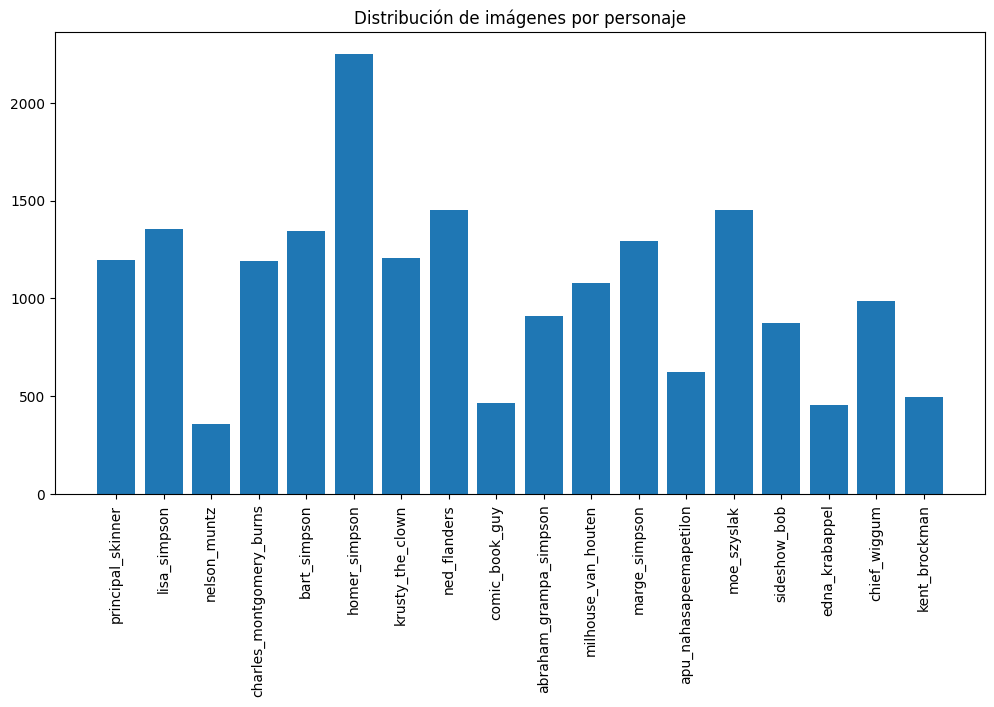

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(y)
labels = [MAP_CHARACTERS[i] for i in counts.keys()]
plt.figure(figsize=(12,6))
plt.bar(labels, counts.values())
plt.xticks(rotation=90)
plt.title("Distribución de imágenes por personaje")
plt.show()


# Balanceo del Dataset

Hemos decidido crear una nuevo dataset en donde creamos una carpeta balanceada y generamos una augmentacion para igualar el numero de imagenes, es decir balancearlo quitando imagenes en los personajes en donde hay muchas imagenes y generando imagenes si le faltan.

Utilizamos Data Augmentacion para esto.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import os
from collections import Counter
import numpy as np

# Crear carpetas temporales balanceadas
BALANCED_DATASET_PATH = '/content/simpsons_balanced'
os.makedirs(BALANCED_DATASET_PATH, exist_ok=True)

# Contar cuántas imágenes tiene cada personaje
train_counts = Counter(y)
max_count = max(train_counts.values())

# Creamos una estructura de carpetas con augmentación para igualar el número de imágenes
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.1,
                             zoom_range=0.1, horizontal_flip=True)

print("Generando dataset balanceado con augmentación...")

for label, character in MAP_CHARACTERS.items():
    src_dir = os.path.join(DATASET_TRAIN_PATH, character)
    dst_dir = os.path.join(BALANCED_DATASET_PATH, character)
    os.makedirs(dst_dir, exist_ok=True)

    images = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]
    num_original = len(images)

    # Copiar imágenes originales
    for fname in images:
        shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

    # Crear imágenes nuevas si tiene menos que el máximo
    if num_original < max_count:
        extra_needed = max_count - num_original
        imgs = [cv2.imread(os.path.join(src_dir, f)) for f in images]
        imgs = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in imgs]

        i = 0
        while extra_needed > 0:
            img = np.expand_dims(imgs[i % num_original], axis=0)
            for batch in datagen.flow(img, batch_size=1, save_to_dir=dst_dir,
                                      save_prefix='aug', save_format='jpg'):
                extra_needed -= 1
                break
            i += 1

print("Dataset balanceado generado.")


Generando dataset balanceado con augmentación...
Dataset balanceado generado.


# Verificamos cantidad de imagenes por personaje

Ahora tenemos entre 2000 a 2250 imagenes por personajes

In [ ]:
X, y = load_train_set("/content/simpsons_balanced", MAP_CHARACTERS)


Leyendo 2155 imágenes encontradas de abraham_grampa_simpson
Leyendo 2132 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 2213 imágenes encontradas de bart_simpson
Leyendo 2194 imágenes encontradas de charles_montgomery_burns
Leyendo 2180 imágenes encontradas de chief_wiggum
Leyendo 2090 imágenes encontradas de comic_book_guy
Leyendo 2095 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 2091 imágenes encontradas de kent_brockman
Leyendo 2194 imágenes encontradas de krusty_the_clown
Leyendo 2206 imágenes encontradas de lisa_simpson
Leyendo 2211 imágenes encontradas de marge_simpson
Leyendo 2175 imágenes encontradas de milhouse_van_houten
Leyendo 2213 imágenes encontradas de moe_szyslak
Leyendo 2224 imágenes encontradas de ned_flanders
Leyendo 2071 imágenes encontradas de nelson_muntz
Leyendo 2205 imágenes encontradas de principal_skinner
Leyendo 2140 imágenes encontradas de sideshow_bob


In [ ]:
X, y = load_train_set(BALANCED_DATASET_PATH, MAP_CHARACTERS)


Leyendo 2155 imágenes encontradas de abraham_grampa_simpson
Leyendo 2132 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 2213 imágenes encontradas de bart_simpson
Leyendo 2194 imágenes encontradas de charles_montgomery_burns
Leyendo 2180 imágenes encontradas de chief_wiggum
Leyendo 2090 imágenes encontradas de comic_book_guy
Leyendo 2095 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 2091 imágenes encontradas de kent_brockman
Leyendo 2194 imágenes encontradas de krusty_the_clown
Leyendo 2206 imágenes encontradas de lisa_simpson
Leyendo 2211 imágenes encontradas de marge_simpson
Leyendo 2175 imágenes encontradas de milhouse_van_houten
Leyendo 2213 imágenes encontradas de moe_szyslak
Leyendo 2224 imágenes encontradas de ned_flanders
Leyendo 2071 imágenes encontradas de nelson_muntz
Leyendo 2205 imágenes encontradas de principal_skinner
Leyendo 2140 imágenes encontradas de sideshow_bob


# Crear Modelo

Normalizamos

In [ ]:
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0


In [ ]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y, num_classes=len(MAP_CHARACTERS))
y_t_cat = to_categorical(y_t, num_classes=len(MAP_CHARACTERS))


Utilizamos un split del 80/20 para garantizar que el modelo se entrene con una porción amplia de datos, reservando el 20% para validación independiente. Esto permite evaluar el rendimiento en datos no vistos y detectar posibles casos de overfitting.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

Utilizamos capas convolucionales con 32, 64 y 128 filtros para que la red aprenda patrones visuales de diferente complejidad. Cada filtro extrae características como bordes, formas o texturas. Finalmente, usamos la función softmax en la salida para convertir los resultados en probabilidades de pertenecer a cada uno de los 18 personajes de Los Simpsons.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


No correr estas 2 celdas, si cargamos solo el modelo b.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = 'mejor_modelo.keras'

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss')
]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convertimos de one-hot a etiquetas numéricas para calcular pesos
y_train_labels = np.argmax(y_train, axis=1)

# Calcular pesos para clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))


# Entrenamiento del modelo

Intentamos con 50 epocas, pero la demora era demasiada y debido a la sesión el limite era 20 aproximadamente, asi que lo redujimos a esta cantidad.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=callbacks,
                    class_weight=class_weights_dict)  # 👈 Aquí se agregan los pesos

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 245s 494ms/step - accuracy: 0.2256 - loss: 2.8670 - val_accuracy: 0.4221 - val_loss: 1.9330
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 255s 481ms/step - accuracy: 0.4647 - loss: 1.8239 - val_accuracy: 0.5970 - val_loss: 1.4042
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 270s 496ms/step - accuracy: 0.5667 - loss: 1.4768 - val_accuracy: 0.6506 - val_loss: 1.2202
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 255s 482ms/step - accuracy: 0.6388 - loss: 1.2235 - val_accuracy: 0.6810 - val_loss: 1.1033
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 261s 480ms/step - accuracy: 0.6864 - loss: 1.0602 - val_accuracy: 0.7024 - val_loss: 1.0182
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 262s 479ms/step - accuracy: 0.7202 - loss: 0.9337 - val_accuracy: 0.7210 - val_loss: 0.9651
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 267s 490ms/step - accuracy: 0.7544 - loss: 0.8134 - val_accuracy: 0.7387 - val_loss: 0.9052
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 240s 492ms/step - accuracy: 0.7812 -



*   Muy buena precisión
*   Puede existir overfitting por la diferencia entre loss y val_loss



In [ ]:
model.save('mejor_modelo_final.keras')


# Caracteristicas del Modelo

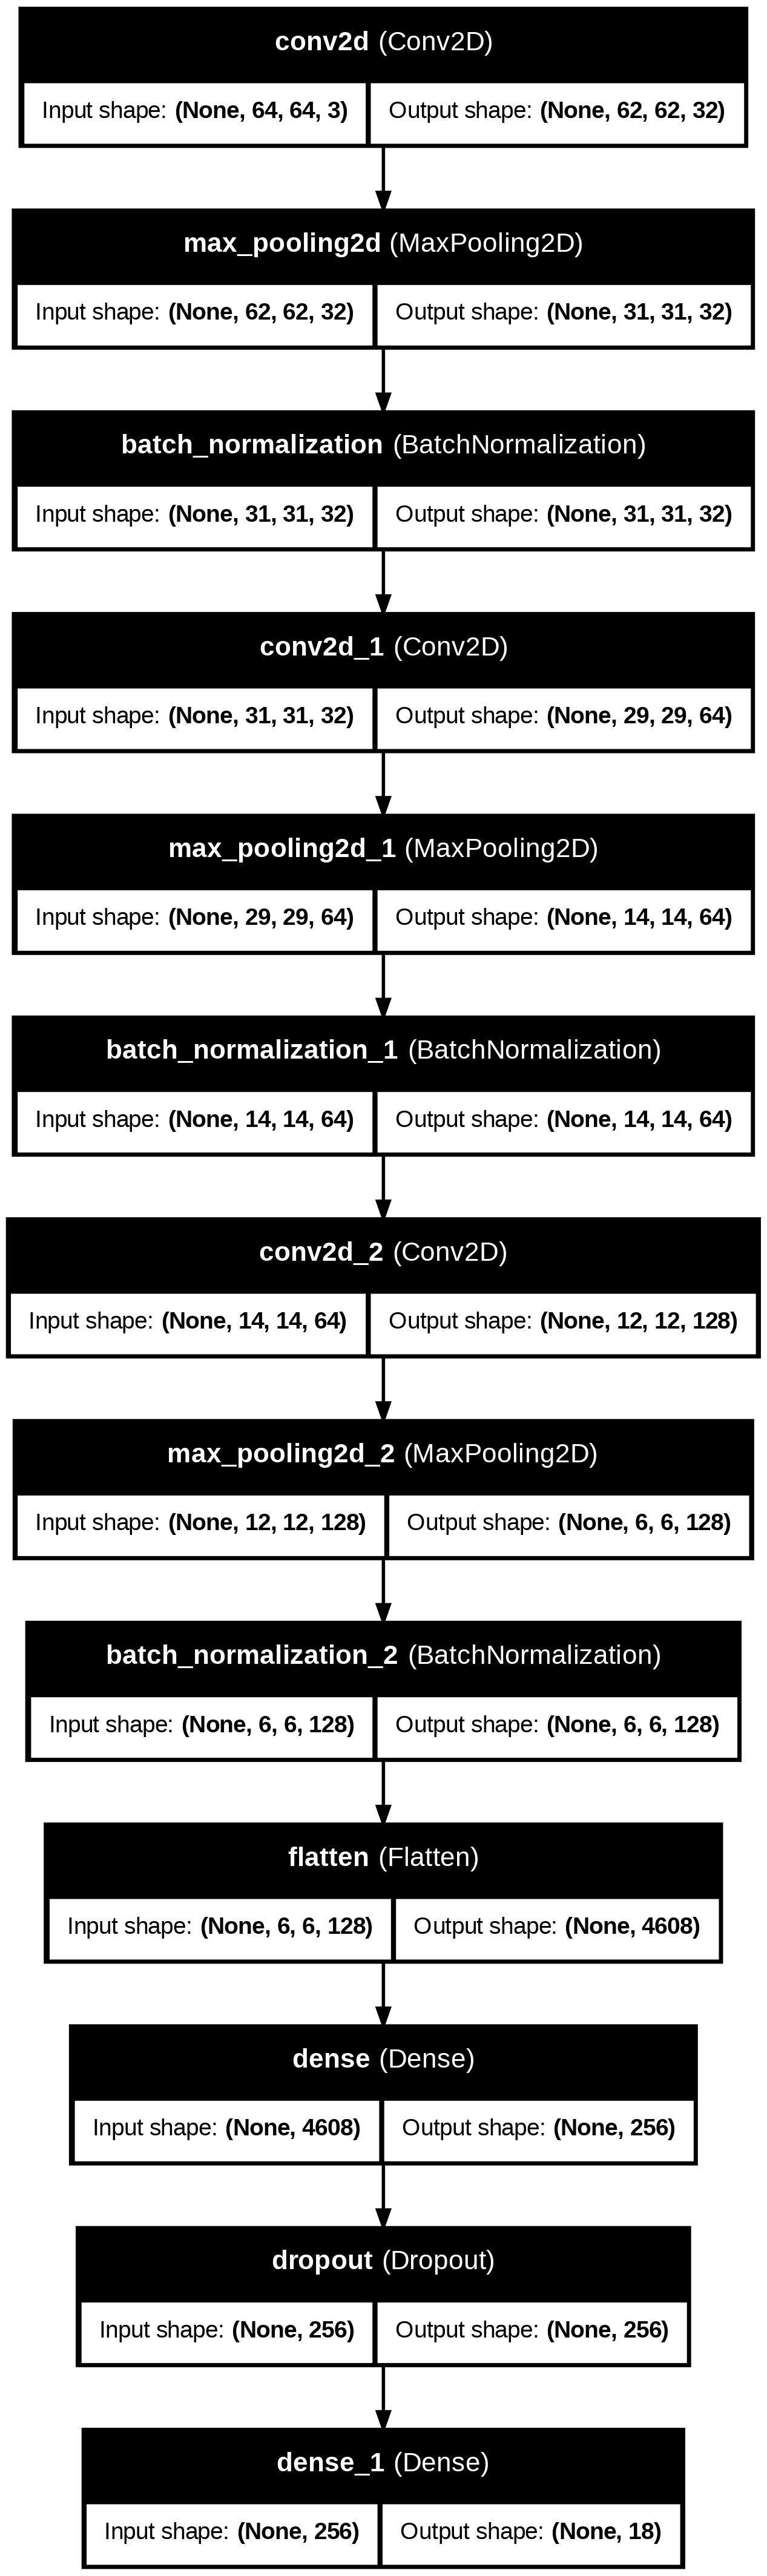

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
!apt-get install graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
model.get_config()


{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name

In [ ]:
model.save("mejor_modelo.keras")  # 🆕 Formato recomendado



# Instalacion de gradio

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


# Reconocimiento de Imagen

In [ ]:
import gradio as gr

def predict_image(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0]
    class_index = np.argmax(prediction)
    confidence = prediction[class_index]
    class_name = MAP_CHARACTERS[class_index]
    return f"{class_name} ({confidence*100:.2f}%)"

iface = gr.Interface(fn=predict_image,
                     inputs=gr.Image(type="numpy"),
                     outputs="text",
                     title="Detector de Personajes de Los Simpsons")
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07f7c0cfb0b229ad3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Reconocimiento de Video

In [ ]:
def predict_video(video):
    cap = cv2.VideoCapture(video)
    frame_count = 0
    results = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 10 == 0:  # cada 10 frames
            img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img)[0]
            class_index = np.argmax(pred)
            char_name = MAP_CHARACTERS[class_index]
            results[char_name] = results.get(char_name, 0) + 1
        frame_count += 1

    cap.release()
    # Mostrar el personaje más frecuente
    if results:
        most_common = max(results.items(), key=lambda x: x[1])
        return f"Personaje más frecuente: {most_common[0]}"
    else:
        return "No se pudo analizar el video."

iface_video = gr.Interface(fn=predict_video,
                           inputs=gr.Video(),
                           outputs="text",
                           title="Identificador de Personajes en Video")
iface_video.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b32dd6b912f39ca2ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


NameError: name 'history' is not defined

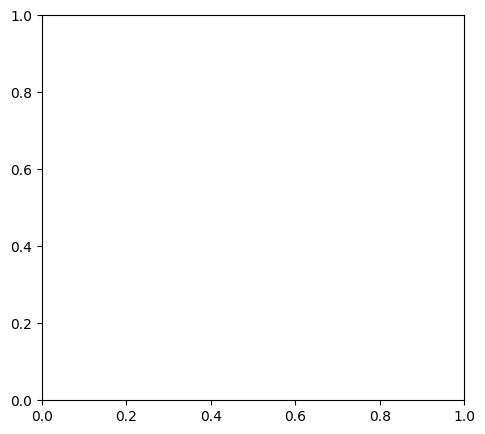

In [ ]:
import matplotlib.pyplot as plt

# Graficar accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Graficar loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


# 1. Generar predicciones en el conjunto de validación para el Modelo A

In [ ]:
import numpy as np

# Predicciones
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step


2. Reporte de clasificación

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]))


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.80      0.78      0.79       458
  apu_nahasapeemapetilon       0.89      0.92      0.90       424
            bart_simpson       0.65      0.66      0.65       435
charles_montgomery_burns       0.78      0.67      0.72       462
            chief_wiggum       0.83      0.89      0.86       386
          comic_book_guy       0.89      0.83      0.86       450
          edna_krabappel       0.84      0.88      0.86       422
           homer_simpson       0.80      0.73      0.76       422
           kent_brockman       0.90      0.92      0.91       423
        krusty_the_clown       0.83      0.88      0.85       450
            lisa_simpson       0.65      0.67      0.66       429
           marge_simpson       0.84      0.85      0.84       442
     milhouse_van_houten       0.83      0.83      0.83       450
             moe_szyslak       0.83      0.74      0.78       443
         

Personajes con más problemas (F1-score más bajo)

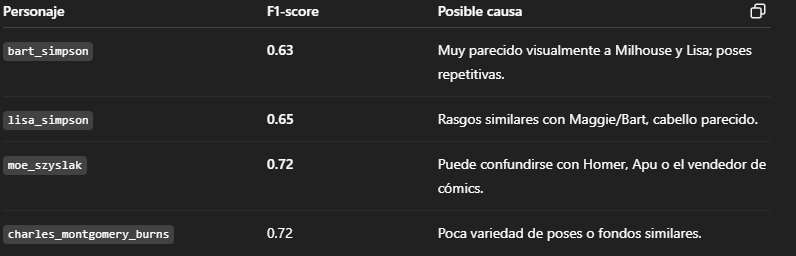


Personajes con mejor desempeño

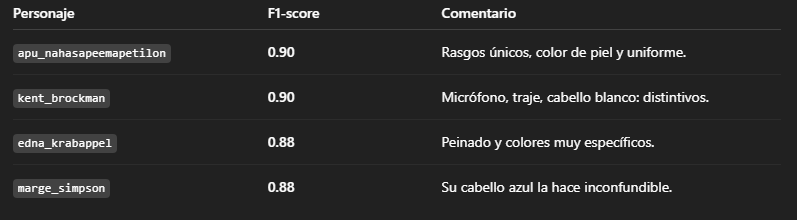

3. Matriz de confusión visual

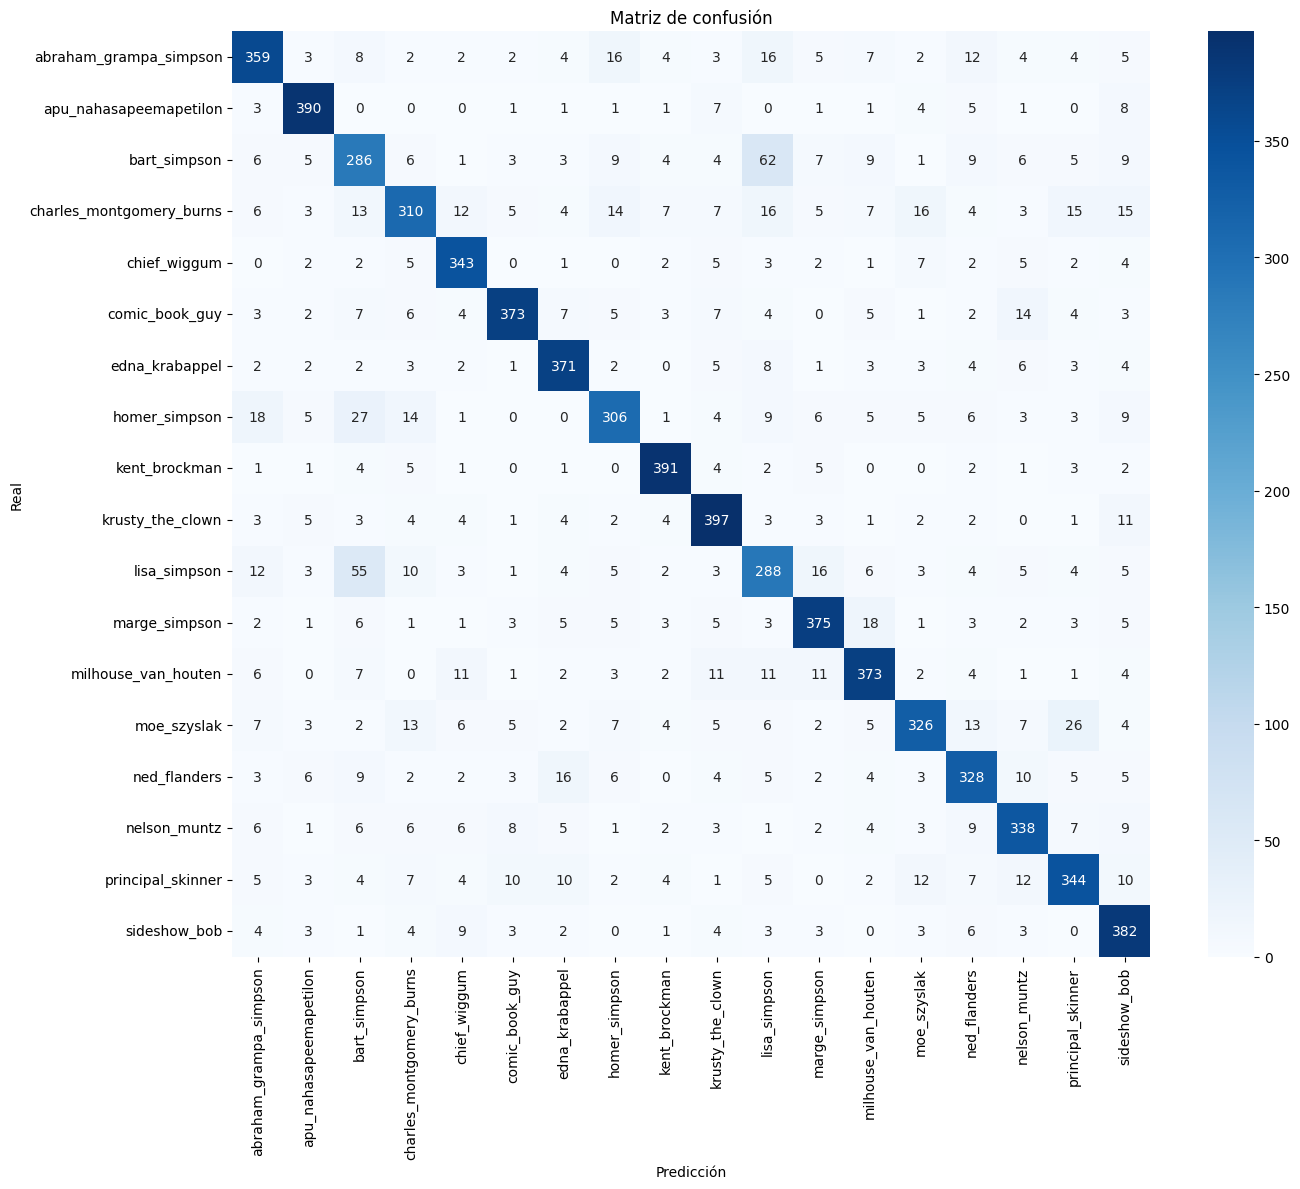

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))],
            yticklabels=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


4. Visualizar ejemplos mal clasificados

Número de errores: 1519


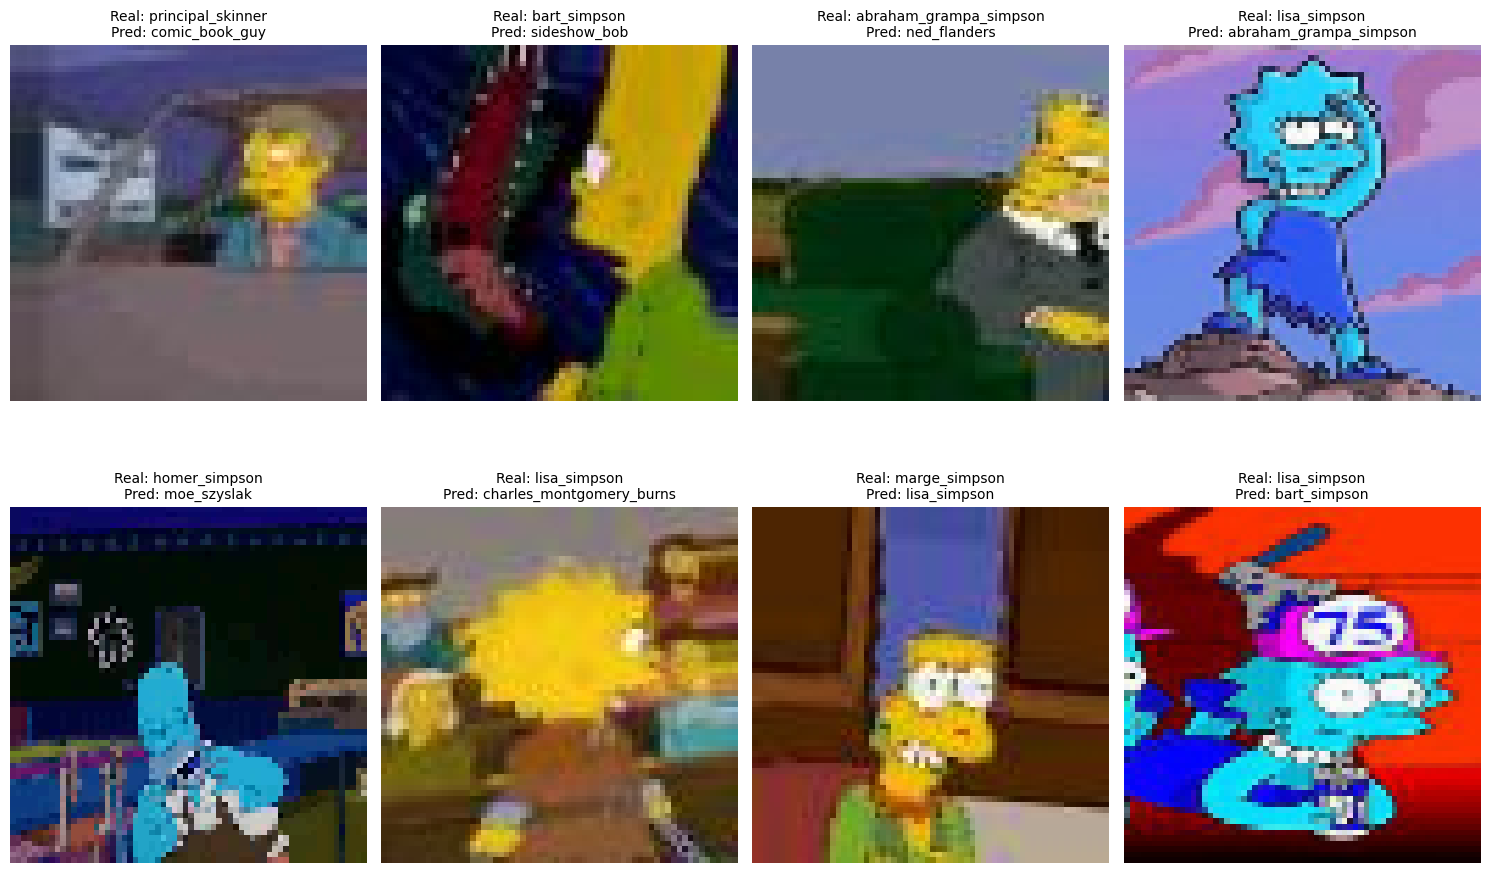

In [ ]:
import random

# Índices donde el modelo se equivocó
errores = np.where(y_true != y_pred)[0]
print(f"Número de errores: {len(errores)}")

# Mostrar algunos errores al azar
num_to_show = 8
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random.sample(list(errores), num_to_show)):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_val[idx])
    real = MAP_CHARACTERS[y_true[idx]]
    pred = MAP_CHARACTERS[y_pred[idx]]
    plt.title(f'Real: {real}\nPred: {pred}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Prueba de un segundo modelo (CNN con capas mas profundas)

Ahora probaremos el modelo con mas capas convolucionales, es decir un modelo mas profundo.

In [ ]:
model_b = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 👇 NUEVA CAPA
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])


No corre si cargamos el modeol_b, ya que ya lo entrenamos

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_b = 'modelo_b.keras'

callbacks_b = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(filepath=checkpoint_b, save_best_only=True, monitor='val_loss')
]

model_b.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_b = model_b.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        batch_size=64,
                        callbacks=callbacks_b,
                        class_weight=class_weights_dict)


  8/488 ━━━━━━━━━━━━━━━━━━━━ 7:29 936ms/step - accuracy: 0.0622 - loss: 4.0210

KeyboardInterrupt: 

# Cargar modelo descargado

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo
model_b = load_model('modelo_b.keras')


In [ ]:
model_b.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,168 (7.52 MB)

 Trainable params: 656,402 (2.50 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,312,806 (5.01 MB)

In [ ]:
# Imagen de prueba
img = X_t[0]  # o cualquier imagen ya preprocesada
img = np.expand_dims(img, axis=0)
pred = model_b.predict(img)
predicted_class = MAP_CHARACTERS[np.argmax(pred)]
print(f"Personaje predicho: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Personaje predicho: sideshow_bob


Este modelo esta mucho mejor, sube 2% de presicion y el val_loss baja casi un 0.2%, de esta forma nuestro val_accuracy sdube a un 0.84%

# **Evaluacion** del modelo B

NameError: name 'history' is not defined

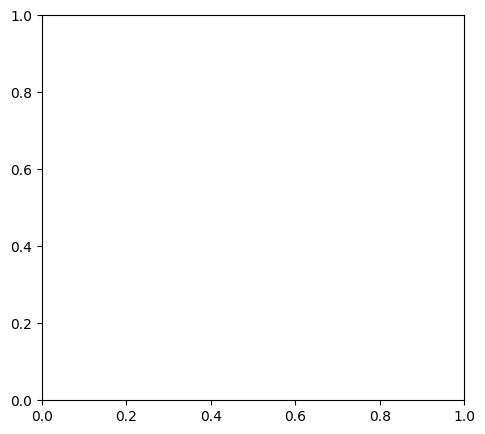

In [ ]:
import matplotlib.pyplot as plt

# Curvas de accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Modelo A')
plt.plot(history_b.history['val_accuracy'], label='Modelo B')
plt.title('Validación - Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Curvas de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Modelo A')
plt.plot(history_b.history['val_loss'], label='Modelo B')
plt.title('Validación - Pérdida (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_b.evaluate(X_val, y_val)  # Esto debería darte un val_accuracy cercano a 0.84



244/244 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9101 - loss: 0.3025


[0.3325131833553314, 0.9041885733604431]

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Asegúrate de que y_val está en one-hot
# Convertimos ambas a etiquetas numéricas
y_true = np.argmax(y_val, axis=1)

# Predicciones del modelo (probabilidades)
y_pred_probs = model_b.predict(X_val)

# Elegimos la clase con mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)

# Reporte
print(classification_report(y_true, y_pred, target_names=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]))


244/244 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.87      0.91      0.89       458
  apu_nahasapeemapetilon       0.93      0.96      0.94       435
            bart_simpson       0.81      0.82      0.82       437
charles_montgomery_burns       0.89      0.85      0.87       458
            chief_wiggum       0.95      0.92      0.93       409
          comic_book_guy       0.92      0.89      0.91       436
          edna_krabappel       0.92      0.90      0.91       411
           homer_simpson       0.94      0.97      0.96       408
           kent_brockman       0.94      0.96      0.95       426
        krusty_the_clown       0.93      0.91      0.92       447
            lisa_simpson       0.85      0.80      0.82       429
           marge_simpson       0.92      0.94      0.93       440
     milhouse_van_houten       0.89      0.92      0.91       431
             moe_szyslak       0

In [ ]:
from tensorflow.keras.models import load_model

# Carga el mejor modelo
modelo = load_model("modelo_b.keras")


In [ ]:
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy',
    6: 'edna_krabappel', 7: 'homer_simpson', 8: 'kent_brockman',
    9: 'krusty_the_clown', 10: 'lisa_simpson', 11: 'marge_simpson',
    12: 'milhouse_van_houten', 13: 'moe_szyslak', 14: 'ned_flanders',
    15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}


In [ ]:
import numpy as np
import cv2

IMG_SIZE = 64  # Asegúrate que sea igual al entrenamiento

def predict_character(image):
    # Preprocesamiento
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)

    # Predicción
    predictions = model_b.predict(image)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]

    character = MAP_CHARACTERS[class_index]
    return f"{character} ({confidence*100:.2f}%)"


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=predict_character,
    inputs=gr.Image(type="numpy", label="Sube una imagen de un personaje"),
    outputs=gr.Text(label="Personaje detectado"),
    title="Reconocimiento de personajes de Los Simpsons",
    description="Modelo B (CNN profundo)"
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2baef7b0a99d2a963c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Reconocimiento** de Video para el Modelo B (Mas capas)

In [ ]:
from tensorflow.keras.models import load_model

modelo = load_model("modelo_b.keras")


In [ ]:
def predict_video(video):
    cap = cv2.VideoCapture(video)
    frame_count = 0
    results = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 10 == 0:  # cada 10 frames
            img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)
            pred = model_b.predict(img)[0]  # ✅ Aquí usamos modelo_b
            class_index = np.argmax(pred)
            char_name = MAP_CHARACTERS[class_index]
            results[char_name] = results.get(char_name, 0) + 1
        frame_count += 1

    cap.release()
    if results:
        most_common = max(results.items(), key=lambda x: x[1])
        return f"Personaje más frecuente: {most_common[0]}"
    else:
        return "No se pudo analizar el video."


In [ ]:
import gradio as gr

iface_video = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(label="Sube un video de Los Simpsons"),
    outputs="text",
    title="Identificador de Personajes en Video",
    description="Usando modelo B (CNN profundo)"
)

iface_video.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4a8420e1e6da06dc32.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import cv2
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model

def predecir_video(video_path):
    print(f"Iniciando procesamiento del video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video en la ruta: {video_path}")
        return "Error: No se pudo abrir el video."

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec .mp4
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video detectado: {total_frames} fotogramas, {fps} FPS, {width}x{height} resolución.")

    output_video_path = "temp_output_video.mp4"
    out = None

    try:
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        if not out.isOpened():
            print(f"Error: No se pudo crear archivo de salida en {output_video_path}")
            return "Error: No se pudo crear el archivo de salida de video."

        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Fin del video o error al leer fotograma.")
                break

            img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)

            pred_prob = model_b.predict(img)
            pred_class_idx = np.argmax(pred_prob, axis=1)[0]
            predicted_character = MAP_CHARACTERS[pred_class_idx]

            cv2.putText(frame, predicted_character, (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            out.write(frame)

            if frame_count % 50 == 0:
                print(f"Fotograma procesado: {frame_count}/{total_frames}")
            frame_count += 1

        print(f"Procesamiento completado: {frame_count} frames.")

    except Exception as e:
        print(f"Error durante el procesamiento: {e}")
        return f"Error durante el procesamiento: {e}"

    finally:
        if cap:
            cap.release()
            print("VideoCapture liberado.")
        if out:
            out.release()
            print("VideoWriter liberado.")

    print(f"Video de salida guardado en: {output_video_path}")
    return output_video_path


iface = gr.Interface(
    fn=predecir_video,
    inputs=gr.Video(label="Sube tu video"),
    outputs=gr.Video(label="Video con Detección de Personajes"),
    title="Detector de Personajes de Los Simpsons",
    description="Sube un video para detectar qué personaje aparece en cada fotograma."
)

iface.launch(debug=True, share=True)



Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b3165df2acd5250418.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Iniciando procesamiento del video: /tmp/gradio/a3b96b54b7b46bce78a6f3995bb583e4f91b657e72cde621272e4f582a539ad3/Hola soy el señor Bolainas Audio Latino - Rodrigo Nicolas 360p, h264.mp4
Video detectado: 1416 fotogramas, 25.0 FPS, 640x360 resolución.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fotograma procesado: 0/1416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1

/usr/local/lib/python3.11/dist-packages/gradio/components/video.py:355: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5fe393184f842bd9ea.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://4a8420e1e6da06dc32.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://b3165df2acd5250418.gradio.live


# 1. Generar predicciones en el conjunto de validación para el Modelo B

In [ ]:
import numpy as np

# Predicciones
y_pred_probs = model_b.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step


2. Reporte de clasificación

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]))


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.87      0.91      0.89       458
  apu_nahasapeemapetilon       0.93      0.96      0.94       435
            bart_simpson       0.81      0.82      0.82       437
charles_montgomery_burns       0.89      0.85      0.87       458
            chief_wiggum       0.95      0.92      0.93       409
          comic_book_guy       0.92      0.89      0.91       436
          edna_krabappel       0.92      0.90      0.91       411
           homer_simpson       0.94      0.97      0.96       408
           kent_brockman       0.94      0.96      0.95       426
        krusty_the_clown       0.93      0.91      0.92       447
            lisa_simpson       0.85      0.80      0.82       429
           marge_simpson       0.92      0.94      0.93       440
     milhouse_van_houten       0.89      0.92      0.91       431
             moe_szyslak       0.89      0.89      0.89       445
         

3. Matriz de confusión visual

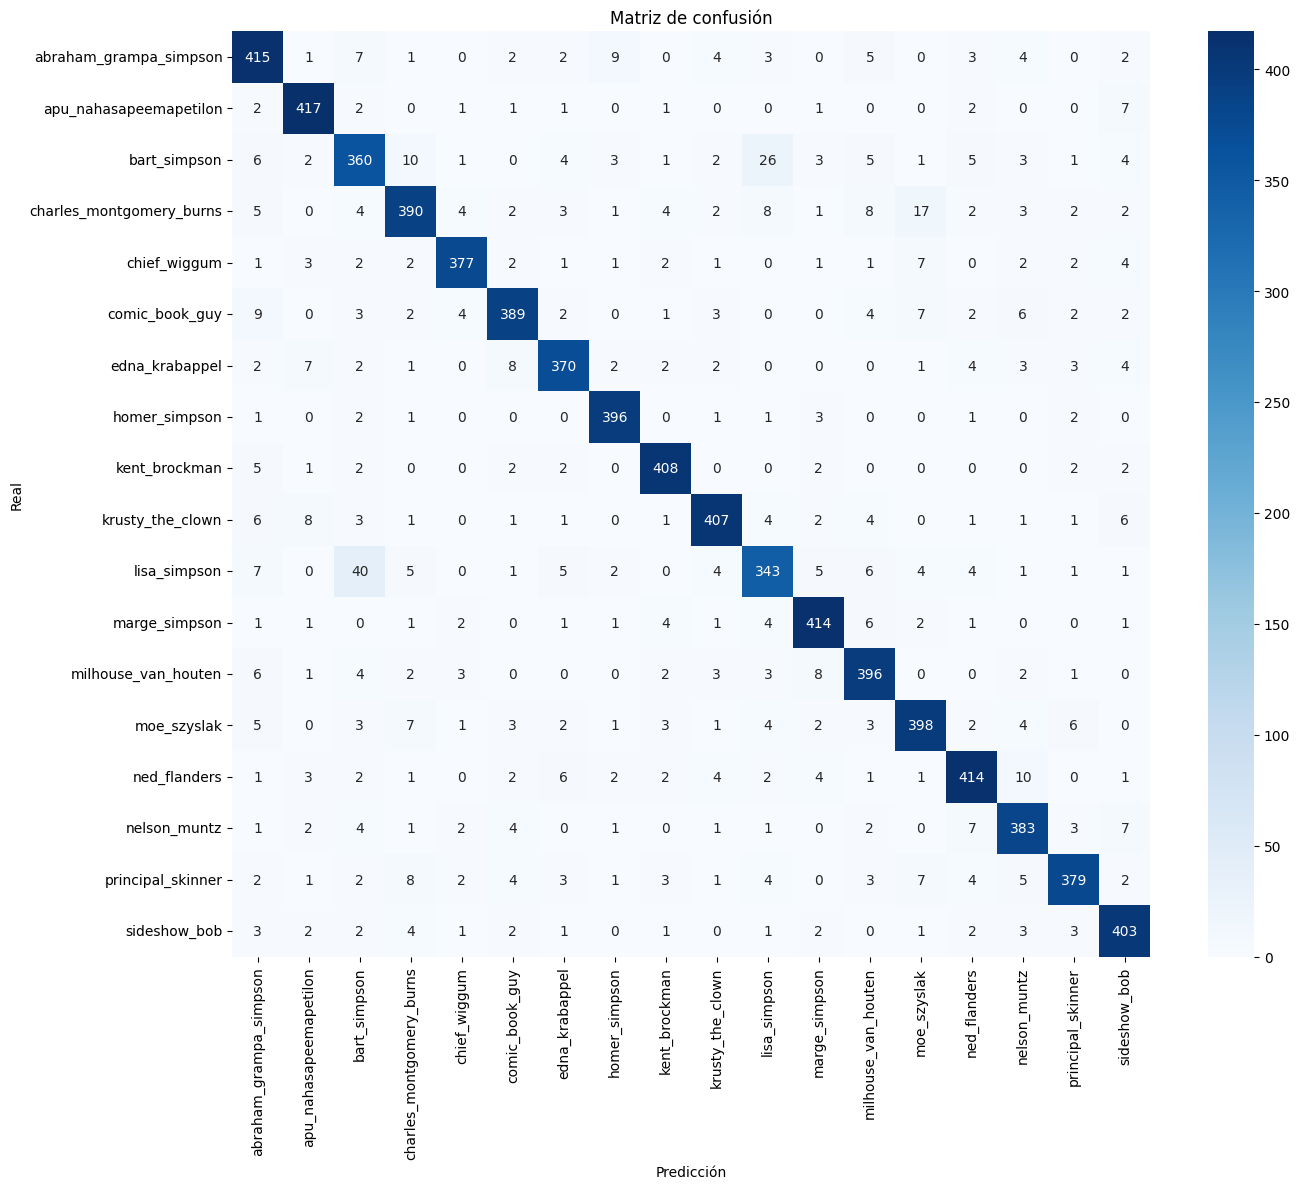

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))],
            yticklabels=[MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


4. Visualizar ejemplos mal clasificados

Número de errores: 748


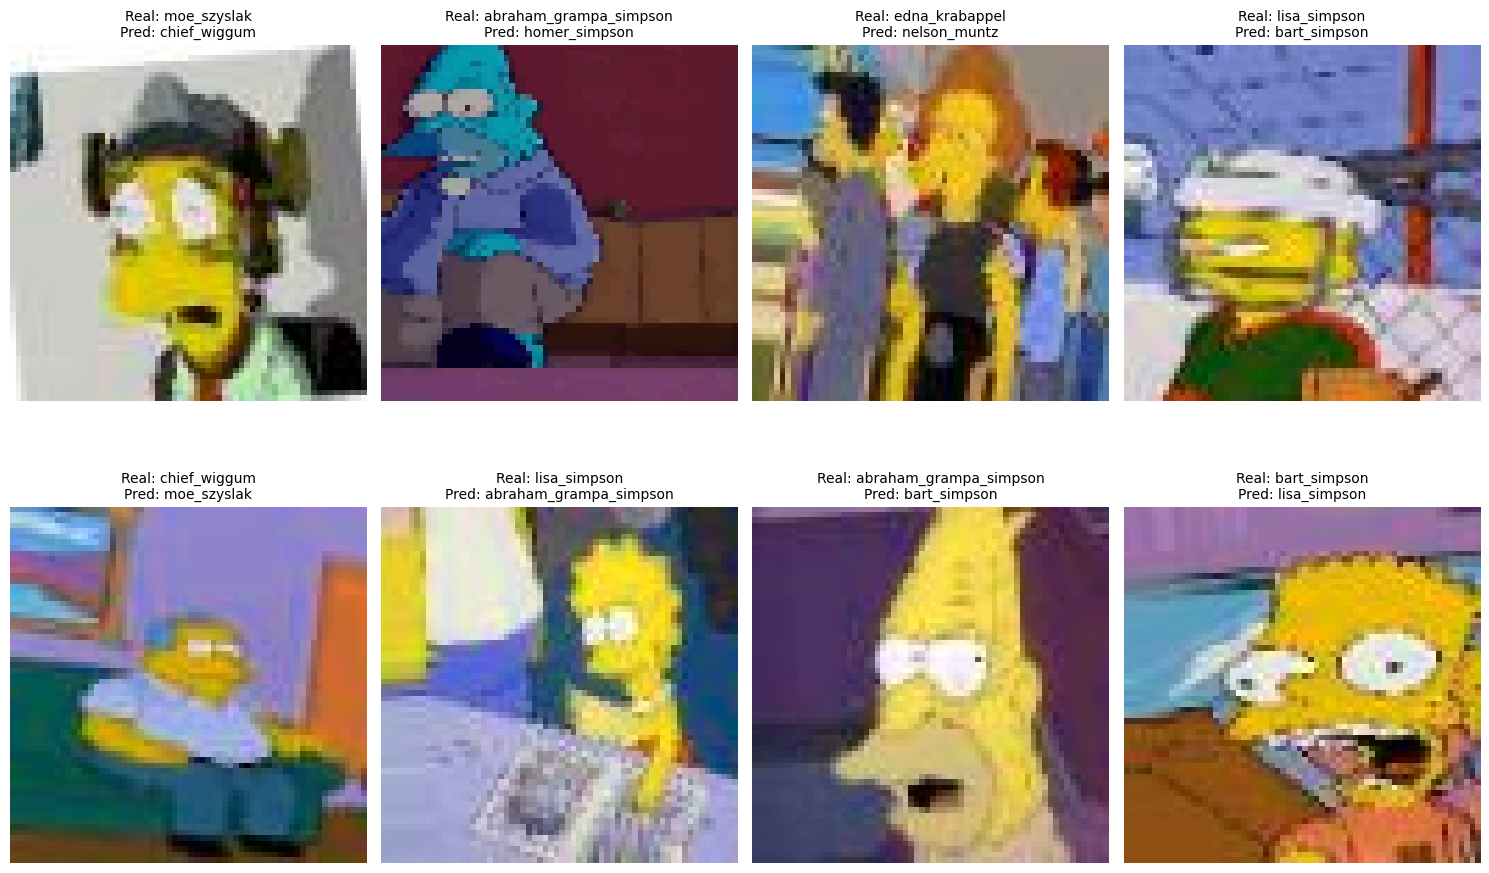

In [ ]:
import random

# Índices donde el modelo se equivocó
errores = np.where(y_true != y_pred)[0]
print(f"Número de errores: {len(errores)}")

# Mostrar algunos errores al azar
num_to_show = 8
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random.sample(list(errores), num_to_show)):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_val[idx])
    real = MAP_CHARACTERS[y_true[idx]]
    pred = MAP_CHARACTERS[y_pred[idx]]
    plt.title(f'Real: {real}\nPred: {pred}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Modelo FullyConnected

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

model_fc = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # Convierte imagen a vector
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_fc = "modelo_fc.keras"

callbacks_fc = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(filepath=checkpoint_fc, save_best_only=True, monitor='val_loss')
]

model_fc.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_fc = model_fc.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=20,
                          batch_size=64,
                          callbacks=callbacks_fc,
                          class_weight=class_weights_dict)


Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - accuracy: 0.0607 - loss: 2.9496 - val_accuracy: 0.0980 - val_loss: 2.8559
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.0813 - loss: 2.8585 - val_accuracy: 0.1401 - val_loss: 2.8044
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.1025 - loss: 2.8118 - val_accuracy: 0.1744 - val_loss: 2.7191
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.1202 - loss: 2.7663 - val_accuracy: 0.2054 - val_loss: 2.6729
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.1394 - loss: 2.7266 - val_accuracy: 0.2036 - val_loss: 2.6435
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.1410 - loss: 2.7115 - val_accuracy: 0.2353 - val_loss: 2.6306
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.1516 - loss: 2.6865 - val_accuracy: 0.2343 - val_loss: 2.5696
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.1558 - loss: 2

El modelo Fully Connected no logra capturar la estructura espacial de las imágenes, lo que impacta negativamente en su capacidad de generalización. En cambio, la CNN utiliza filtros que extraen características locales, lo que mejora su rendimiento en tareas visuales